Here I intend to implement a novelty-facilitated Hopfield model FOR FUN. Hector Sainvet, April 2022.

Ref: Dynamics of memory Representations in networks with Novelty-facilitated Synaptic Plasticity (Blumenfeld et al., 2006)

In [1]:
# Config
config = 32 #8, 16, 32

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas

In [3]:
def plot_matrix(A, xlabel=None, ylabel=None, title='', fname='', colorbar = False):
    plt.figure(1)
    plt.imshow(A, cmap = 'gray')
    if colorbar == True: plt.colorbar()
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    #x = A.shape[1]
    #plt.xticks(np.arange(0, x, 1.0))
    plt.title(title)
    plt.savefig('C:/Users/Hector/Documents/PhD/Stage_Fig/SynapticNovelty/{}/'.format(config)+fname)
    plt.show()

# 1. Initialize F to N sequence on n neurons

In [4]:
def init_env_morph(n=4*config):
    ''' Return environement sequence with n neurons (multiple of 4) and p patterns
        At each pattern, half of the neurons are +1 and half of the neurons are -1. Two neurons change sign at each step of the sequence'''
    n_4 = int(n/4) # config
    p = int(n_4+1)
    env = np.zeros((p,n))
    env[0] = np.concatenate([-np.ones(n_4), np.ones(n_4), -np.ones(n_4), np.ones(n_4)], axis = 0)
    u,v = int(3*n_4)-1, -1
    for k in range(1,p):
        tmp = np.copy(env[k-1])
        tmp[u] *= -1
        tmp[v] *= -1
        env[k] = tmp
        u -= 1
        v -= 1
    return env, p, n

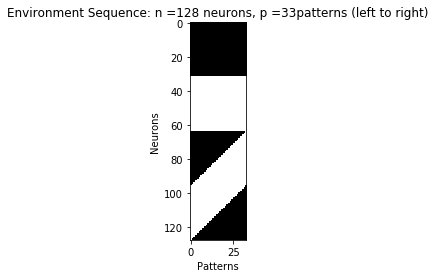

In [5]:
env_morph, p, n = init_env_morph()
plot_matrix(env_morph.T, fname='EnvSeq', title = 'Environment Sequence: n ={} neurons, p ={}patterns (left to right)'.format(n,p), xlabel = 'Patterns', ylabel='Neurons')

In [6]:
def init_env_F2N(n=4*config):
    ''' Return environement sequence with n neurons (multiple of 4) and p patterns
        At each pattern, half of the neurons are +1 and half of the neurons are -1. Two neurons change sign at each step of the sequence'''
    n_4 = int(n/4) # config
    p = int(n_4+1)
    env = np.zeros((p,n))
    env[0] = np.concatenate([-np.ones(n_4), np.ones(n_4), -np.ones(n_4), -np.ones(n_4)], axis = 0)
    for k in range(1,p//2):
        tmp = np.copy(env[k-1])
        env[k] = tmp
    #u,v = int(2*n_4)-1, -1
    env[p//2] = np.concatenate([-np.ones(n_4), -np.ones(n_4), -np.ones(n_4), np.ones(n_4)], axis = 0)
    for k in range(p//2+1,p):
        tmp = np.copy(env[k-1])
        env[k] = tmp
    return env, p, n

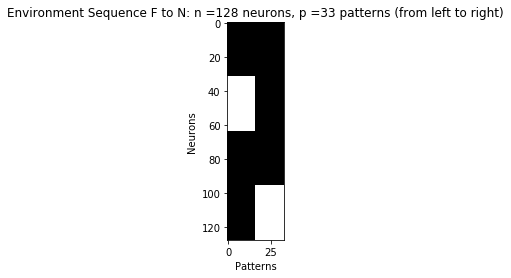

In [7]:
env_F2N, p, n = init_env_F2N()
plot_matrix(env_F2N.T, fname='EnvSeq', title = 'Environment Sequence F to N: n ={} neurons, p ={} patterns (from left to right)'.format(n,p), xlabel = 'Patterns', ylabel='Neurons')

In [8]:
def init_env_F2F(n=4*config):
    ''' Return environement sequence with n neurons (multiple of 4) and p patterns
        At each pattern, half of the neurons are +1 and half of the neurons are -1. Two neurons change sign at each step of the sequence'''
    n_4 = int(n/4) # config
    p = int(n_4+1)
    env = np.zeros((p,n))
    env[0] = np.concatenate([-np.ones(n_4), np.ones(n_4), -np.ones(n_4), -np.ones(n_4)], axis = 0)
    for k in range(1,p):
        tmp = np.copy(env[k-1])
        env[k] = tmp
    return env, p, n

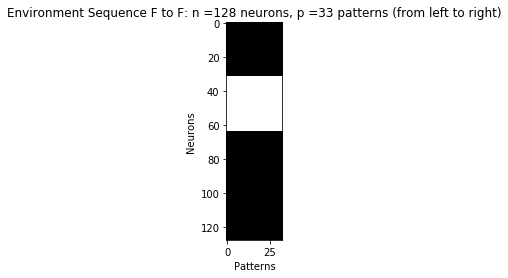

In [9]:
env_F2F, p, n = init_env_F2F()
plot_matrix(env_F2F.T, fname='EnvSeq', title = 'Environment Sequence F to F: n ={} neurons, p ={} patterns (from left to right)'.format(n,p), xlabel = 'Patterns', ylabel='Neurons')

# 2. Weighted Hebbian learning Rule

In [10]:
def Hebb(env=env_morph, weights=1.):
    J = (env*np.sqrt(weights)).T.dot((env*np.sqrt(weights)))/env.shape[1]
    for i in range(J.shape[0]): J[i][i]=0.
    return J

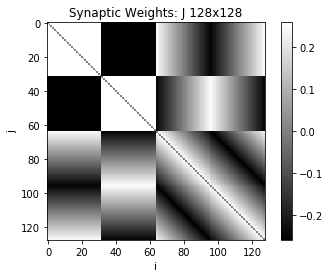

In [11]:
J_morph = pandas.DataFrame(Hebb(env_morph, weights=1.))
J_morph
plot_matrix(J_morph, fname='Hopfield_Synapses', xlabel='i', ylabel='j', title='Synaptic Weights: J {}x{}'.format(J_morph.shape[0], J_morph.shape[1]), colorbar=True)

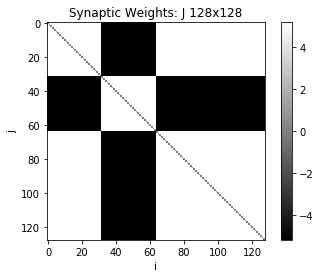

In [12]:
J_F2F = pandas.DataFrame(Hebb(env_F2F, weights=20))
J_F2F
plot_matrix(J_F2F, fname='Hopfield_Synapses', xlabel='i', ylabel='j', title='Synaptic Weights: J {}x{}'.format(J_F2F.shape[0], J_F2F.shape[1]), colorbar=True)

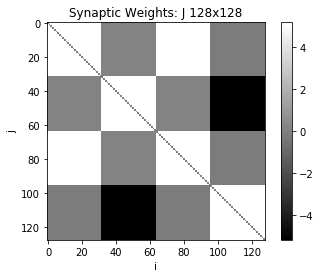

In [13]:
J_F2N = pandas.DataFrame(Hebb(env_F2N, weights=20))
J_F2N
plot_matrix(J_F2N, fname='Hopfield_Synapses', xlabel='i', ylabel='j', title='Synaptic Weights: J {}x{}'.format(J_F2N.shape[0], J_F2N.shape[1]), colorbar=True)

# 3. Dynamics 

In [14]:
def hamming_dist(array1, array2):
    norm = int(np.shape(array1)[0]/2)
    return np.sum([1 for diff in np.abs(array2-array1) if diff!=0])/norm

def one_steps(s_t, J):
    return np.sign(J.dot(s_t))

def dynamic(s_0, J, n_iter_max=100):
    s_t = s_0
    for t in range(n_iter_max):
        s_ = one_steps(s_t, J)
        if t==0:
            H = hamming_dist(s_0, s_)
            #print('H ',H)
        if np.sum(np.abs(s_-s_t))<1/J.shape[0]:
            return s_, H
        s_t = s_
    #print('s_t ',s_t)
    return s_t, H

# 3.1. Standard Hopfield Model

In [15]:
def Hopfield_Net(env=env_morph, plot_J = False, plot_A = False):
    J = Hebb(env)
    if plot_J:
        plot_matrix(J, fname='Hopfiled_Synapses', xlabel='i', ylabel='j', title='Synaptic Weights: J {}x{}'.format(J.shape[0], J.shape[1]), colorbar=True)
    attractors = np.zeros((p,n))
    for i, stimuli in enumerate(env):
        attractors[i], H = dynamic(s_0=stimuli, J=J)
    p_ = np.unique(attractors, axis=0).shape[0]
    if plot_A:
        plot_matrix(attractors.T, fname='Hopfield_EnvAttractors', xlabel='Env sequence', ylabel = 'Attractor state', title='{} stimuli --> {} attractors (Standard Model)'.format(p,p_))
    return J

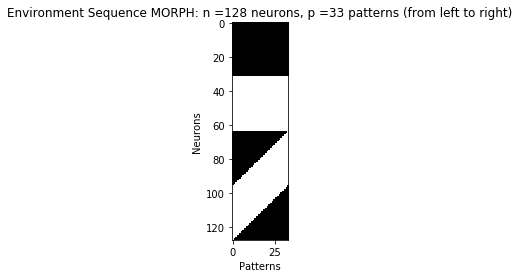

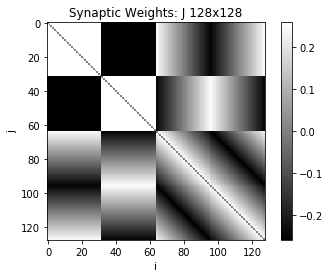

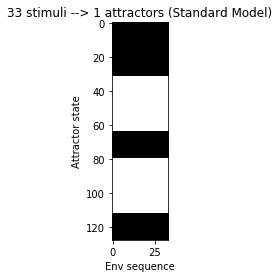

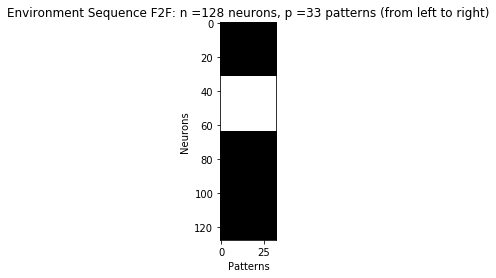

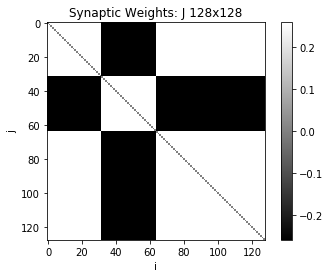

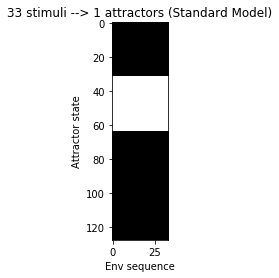

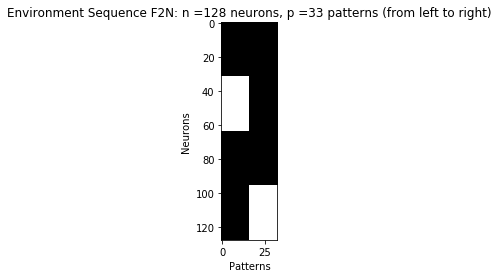

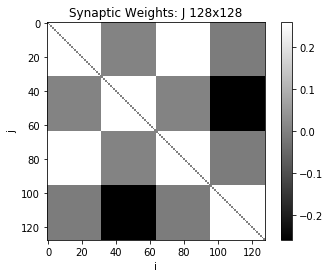

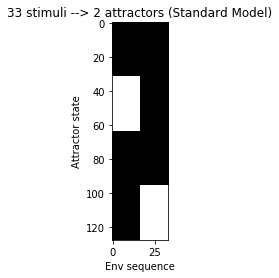

In [16]:
env_list = [env_morph,env_F2F,env_F2N]
env_list_name=['MORPH','F2F','F2N']
for i,e in enumerate(env_list):
    plot_matrix(e.T, fname='EnvSeq', title = 'Environment Sequence {}: n ={} neurons, p ={} patterns (from left to right)'.format(env_list_name[i],n,p), xlabel = 'Patterns', ylabel='Neurons')
    Hopfield_Net(env=e, plot_J=True, plot_A=True)

## 3.2 Novelty-facilitated synaptic plasticity

(## 3.2. Protocol)

In [38]:
def normalize(w):
    return w.shape[0]*w/np.sum(w)

def init_weights(p, prior='uniform',env=env_morph):
    if prior=='skewed':
        w_ = np.expand_dims((np.arange(p)/(p-1)-0.5)**2, 1) # gradual bias toward source and target
    elif prior=='biased':
        w_ = np.zeros(p)
        w_[0], w_[-1] = 1, 1
        w_ = np.expand_dims(w_, 1)
    else: # 'uniform'
        w_ = np.expand_dims(np.ones(p), 1) # uniform distribution
    w_ = normalize(w_)
    J_ = Hebb(env, weights=w_)
    return w_, J_

def update_weights(w, i, H, eta=0.5, env=morph):
    w_ = np.copy(w)
    w_[i] = w_[i] + eta*H
    w_ = normalize(w_)
    J_ = Hebb(env, weights=w_)
    return w_, J_

NameError: name 'morph' is not defined

In [37]:
w,J = init_weights(p, prior="skewed")

NameError: name 'init_weights' is not defined

In [ ]:
def memorize(protocol='Gradual', prior='uniform', epoch=1000, plot_S = True, plot_J = True, plot_A = False, env=morph):
    w, J = init_weights(p, prior=prior, env=env)

    weights = [w.flatten()]
    attractors = np.zeros((p,n))
    for _ in range(epoch):
        index = np.arange(p) # gradual protocol
        if protocol==1: # mixed protocol
            np.random.shuffle(index)

        for i in index: #gradual
            attractors[i], H = dynamic(s_0=env[i], J=J)
            #print(H)
            w, J = update_weights(w=w, i=i, H=H, env=env)
        weights.append(w.flatten())

        if np.sum(np.abs(attractors-env))==0:
            print('Protocol {}, with {} initialization, converged in {} iterations'.format(protocol, prior, _+1))
            break   

    if plot_S:
        plot_matrix(np.array(weights), fname='Saliency_Weights{}_{}'.format(protocol, prior), xlabel='Pattern', ylabel='Epoch', title='Saliency weights: {} patterns (converged in {} iterations)'.format(p, _+1), colorbar=True)
    if plot_J:
        plot_matrix(J, fname='Novelty_Synapses{}_{}'.format(protocol, prior), xlabel='i', ylabel='j', title='Synaptic Weights J: {}x{}'.format(J.shape[0], J.shape[1]), colorbar=True)
    if plot_A: 
        p_ = np.unique(attractors, axis=0).shape[0]
        plot_matrix(attractors.T, fname='Novelty_MorphAttractors', xlabel='Morph sequence', ylabel='Attractor state', title='{} stimuli --> {} attractors (Novelty Facilitated Model)'.format(p,p_))
    
    return w, J

In [ ]:
_,_ = memorize(prior='uniform', plot_S=True, plot_J=True, plot_A=True, env=env_F2F) # gradual, uniform init
_,_ = memorize(prior='biased', env=env_F2F) # gradual, biased init
_,_ = memorize(prior='skewed', env=env_F2F) # gradual, skewed init

In [ ]:
_,_ = memorize(prior='uniform', plot_S=True, plot_J=True, plot_A=True, env=env_F2N) # gradual, uniform init
_,_ = memorize(prior='biased', env=env_F2N) # gradual, biased init
_,_ = memorize(prior='skewed', env=env_F2N) # gradual, skewed init

# 4. Energy and Stability analysis

## 4.1. Lyapunov function (energy)

In [11]:
def E(s,J):
    return -.5*s.dot(J.dot(s))

## 4.2. Attractor Manifold & Stability

In [12]:
from sklearn.decomposition import PCA
colors={0: 'red', 1:'blue', 2:'grey', 3:'yellow', 4:'green', 5:'purple', 6:'pink', 7:'orange', 8:'beige',
        9: 'aqua'}
for i in range(10):
    colors[i+10]=colors[i]
    colors[i+20]=colors[i]
    colors[i+30]=colors[i]

In [158]:
def bassins_of_attract(J, name='', env=morph, noisy=False, switch=False):
    stimuli, Es = [], []
    attractors = []
    
    # ideal stimulus = inprinted patterns
    for i, stimulus in enumerate(env):
        stimuli.append(np.expand_dims(stimulus,0)) # stimulus
        Es.append(E(s=stimulus, J=J)) # energy
        attractor, H = dynamic(s_0=stimulus, J=J)
        attractors.append(np.expand_dims(attractor,0)) # attractor
        
    # noisy stimulus
    if noisy==True:
        for switch in [+1,-1]:
            for j in range(int(n/2),n): # add noise to neuron j
                for i, stimulus in enumerate(env):
                    noisy_stimulus = np.copy(stimulus)
                    if noisy_stimulus[j] != switch: # turn neuron on (over-complete pattern) or off (under-complete pattern)
                        noisy_stimulus[j] = switch
                        stimuli.append(np.expand_dims(noisy_stimulus,0)) # stimulus
                        Es.append(E(s=noisy_stimulus, J=J)) # energy
                        attractor, H = dynamic(s_0=noisy_stimulus, J=J)
                        attractors.append(np.expand_dims(attractor,0)) # attractor
                    
    if switch==True:
        s_F = np.concatenate([-np.ones(config), np.ones(config), -np.ones(config), -np.ones(config)], axis = 0)
        s_N = np.concatenate([-np.ones(config), -np.ones(config), -np.ones(config), np.ones(config)], axis = 0)
        for i in range(len(env)):
            s=s_F
            if np.random.uniform()<0.5:
                s=s_N
            for _ in range(len(env)//5):
                stimuli.append(np.expand_dims(s,0)) # stimulus
                Es.append(E(s=s, J=J)) # energy
                attractor, H = dynamic(s_0=s, J=J)
                attractors.append(np.expand_dims(attractor,0)) # attractor
            
    
                    
    stimuli = np.concatenate(stimuli, axis=0) # stimulus
    Es = np.array(Es) # energy
    unique_A, indices = np.unique(np.concatenate(attractors, axis=0), axis=0, return_inverse=True) # attractor
    #print(unique_A)
    
    # find fixed points id (stimuli, Es)
    attr_id = [] 
    for i,s in enumerate(stimuli):
        dist2_memories = np.array([hamming_dist(s,attr) for attr in unique_A])
        #print(dist2_memories)
        if 0. in dist2_memories:
            attr_id.append(i)
    #print(attr_id)
    Ea = Es[np.array(attr_id)] # attractor energy

    # Plot Input
    plot_matrix(stimuli.T, fname='Noisy_Stimuli', ylabel='Neurons', xlabel='Stimuli', title='{} stimuli encoded with {} neurons (left to right)'.format(stimuli.shape[0], stimuli.shape[1]))
    
    # Plot Output
    plot_matrix(np.concatenate(attractors, axis=0).T, fname= name+'_Recall', ylabel='Attractor State', xlabel='Stimuli', title='Retrieved memories (left to right)')
    
    # Plot Bassins of attraction (Stimuli + Energy + Cluster)
    '''plt.figure(1)
    my_pca = PCA(n_components=1)
    unique_A = my_pca.fit_transform(unique_A)
    stimuli = my_pca.transform(stimuli)
    for i, attr in enumerate(unique_A):
        plt.plot([attr[0]], [Ea[i]], marker='o', color=colors[i], markersize=11) # attractor pattern
        basin_attr = stimuli[np.where(indices==i)[0]] # stimuli in attractor bassin
        plt.scatter(basin_attr[:,0], Es[np.where(indices==i)[0]], marker='+', color=colors[i])
    plt.title('{} bassins of attraction (PCA(k=1) on attractor states)'.format(unique_A.shape[0]))
    plt.xlabel('1st PCA component of stimuli neural code')
    plt.ylabel('Energy')
    plt.savefig('C:/Users/Hector/Documents/PhD/Stage_Fig/SynapticNovelty/{}/{}_PCA'.format(config,name))
    plt.show()'''
    
    # Plot Energy levels (attractors ie local minima in green)
    '''plt.figure(1)
    plt.bar(np.arange(env.shape[0]), Es[:morph.shape[0]], color='red', label='stimuli', align='edge')
    plt.bar(attr_id, Ea, color='green', label='fixed points', align='edge')
    plt.xlim(0., morph.shape[0])
    plt.ylim(min(Es)-1,max(Es)+1)
    plt.ylabel('Energy')
    plt.xlabel('Patterns')
    plt.title('Energy distribution. Green Patterns = Fixed points (local minima of E)')
    plt.savefig('C:/Users/Hector/Documents/PhD/Stage_Fig/SynapticNovelty/{}/{}_MorphEnergy'.format(config,name))
    plt.show()'''

### Standard Hopfield model

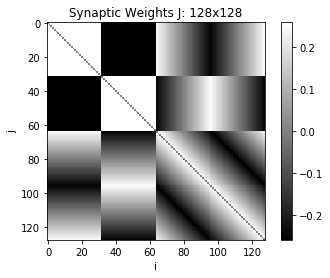

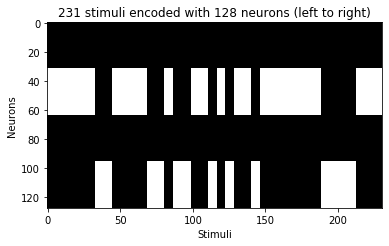

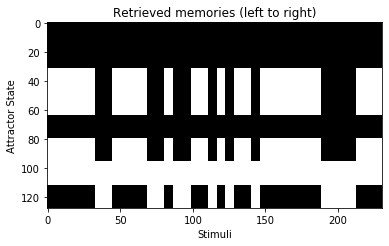

In [164]:
# Standard Hopfield Network
J = Hopfield_Net(env=env_morph) 
plot_matrix(J, fname='Novelty_Synapses', xlabel='i', ylabel='j', title='Synaptic Weights J: {}x{}'.format(J.shape[0], J.shape[1]), colorbar=True)
bassins_of_attract(J, name='Hopfield', env=env_F2F, switch=True)


### Train on F2F/Test on F2F

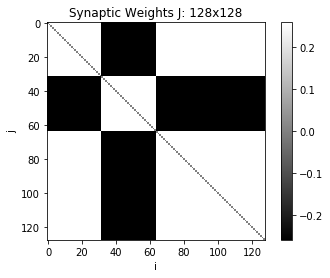

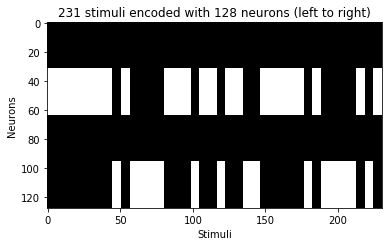

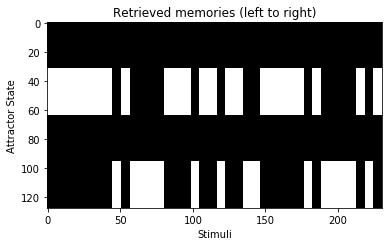

In [159]:
# Standard Hopfield Network
J = Hopfield_Net(env=env_F2F) 
plot_matrix(J, fname='Novelty_Synapses', xlabel='i', ylabel='j', title='Synaptic Weights J: {}x{}'.format(J.shape[0], J.shape[1]), colorbar=True)
bassins_of_attract(J, name='Hopfield', env=env_F2F, switch=True)


### Train on F2F/Test on F2N

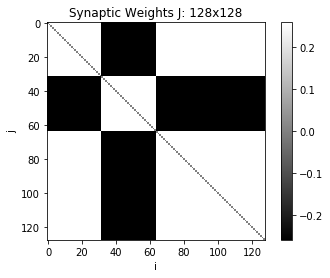

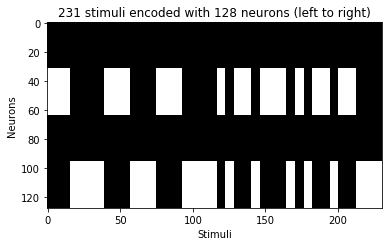

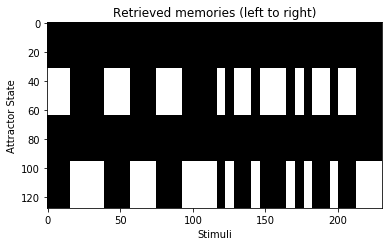

In [163]:
# Standard Hopfield Network
J = Hopfield_Net(env=env_F2F) 
plot_matrix(J, fname='Novelty_Synapses', xlabel='i', ylabel='j', title='Synaptic Weights J: {}x{}'.format(J.shape[0], J.shape[1]), colorbar=True)
bassins_of_attract(J, name='Hopfield', env=env_F2N, switch=True)


## Novelty dynamics

Protocol Gradual, with biased initialization, converged in 1 iterations


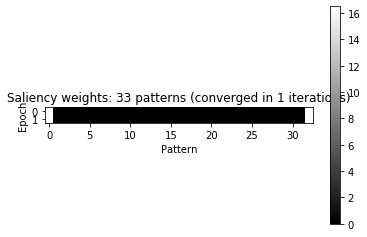

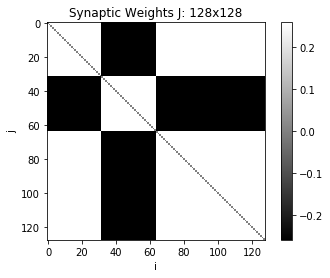

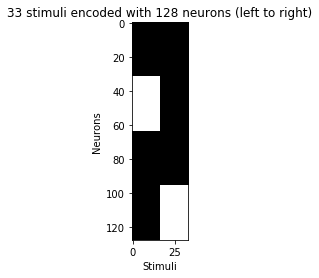

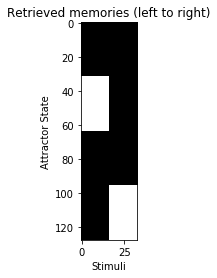

Protocol Gradual, with skewed initialization, converged in 1 iterations


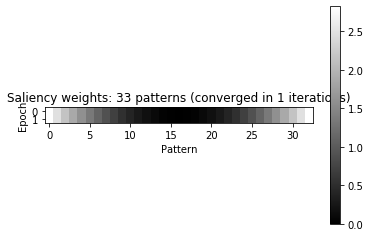

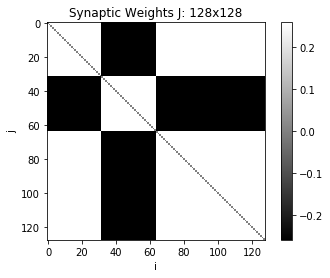

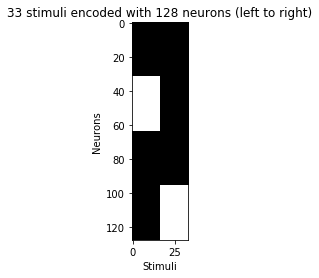

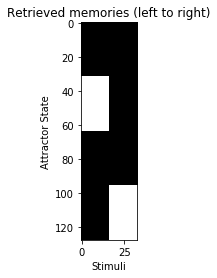

Protocol Gradual, with uniform initialization, converged in 1 iterations


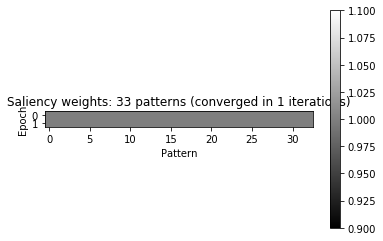

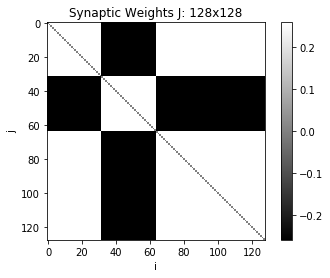

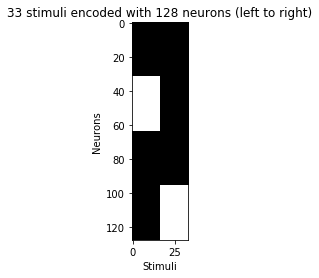

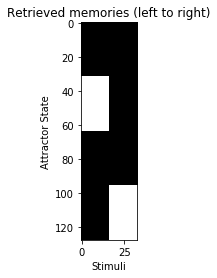

In [165]:
# Novelty dynamics
for protocol_ in ['Gradual']: 
    for prior_ in ['biased','skewed','uniform']:
        try:
            w,J = memorize(protocol=protocol_, prior=prior_, env=env_F2F)
            bassins_of_attract(J, name='Novelty{}_{}'.format(protocol_, prior_), env=env_F2N)
        except:
            pass

# TEST